# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

### JSON to DataFrame

In [3]:
players_df = pd.DataFrame(players)

events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

### Some data preparation

In [4]:
players_df = prepare_players(players_df)

Rimuovo tutti gli eventi con goal kick come subEventName perché sono tutti eventi che hanno come posizione iniziale o (0, 0) o (100, 100), perché si assume che vengano tutti eseguiti da un portiere e nella propria area di rigore. ref: https://dataglossary.wyscout.com/goal_kick/ (<b>The starting position for goal kick is not tagged, assuming it happens all the time in own penalty area.</b>)

In [5]:
for nation in events_df:
    events_df[nation] = events_df[nation][events_df[nation]['subEventName'] != 'Goal Kick']

## Italian first division analysis

In [6]:
italian_events_df = prepare_events(extract_events(events_df, 'Italy'))

In [7]:
events_players_df = pd.merge(italian_events_df, players_df, on='playerId', how='left')

In [8]:
events_players_distances_df = compute_distance(events_players_df)

In [9]:
italian_tmp_df = sum_distances(events_players_distances_df)

In [10]:
distances_count = count_distances(italian_tmp_df)

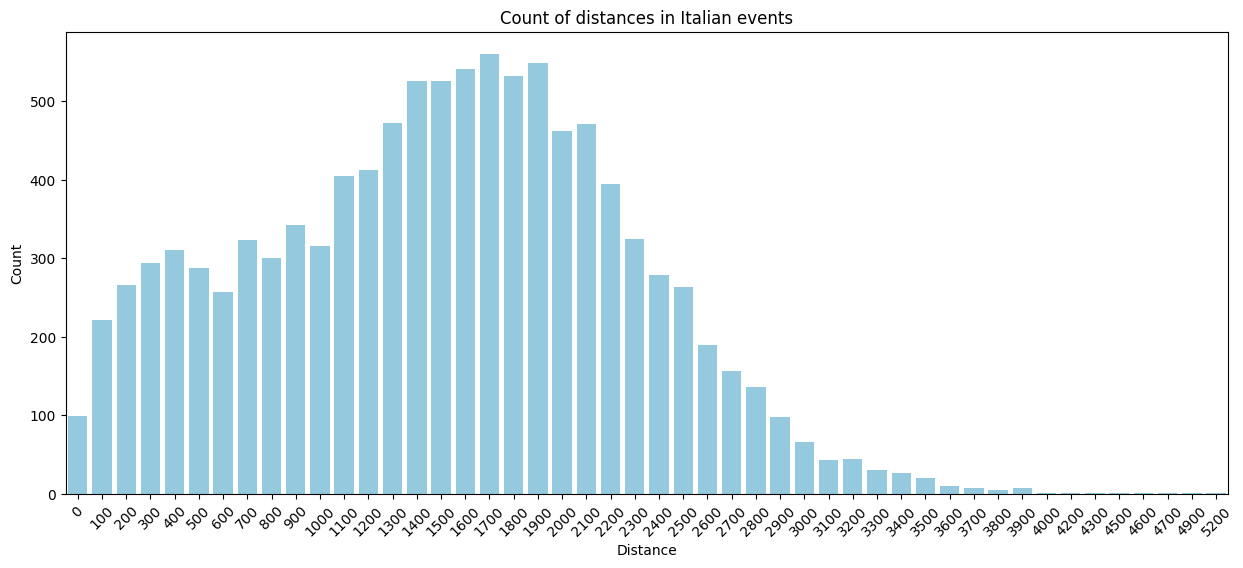

In [11]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in Italian events')

In [12]:
italian_players_role_distances_df = pd.merge(italian_tmp_df, players_df, on='playerId', how='left')

In [13]:
players_role_distances_df = group_by_distance_role(italian_players_role_distances_df)

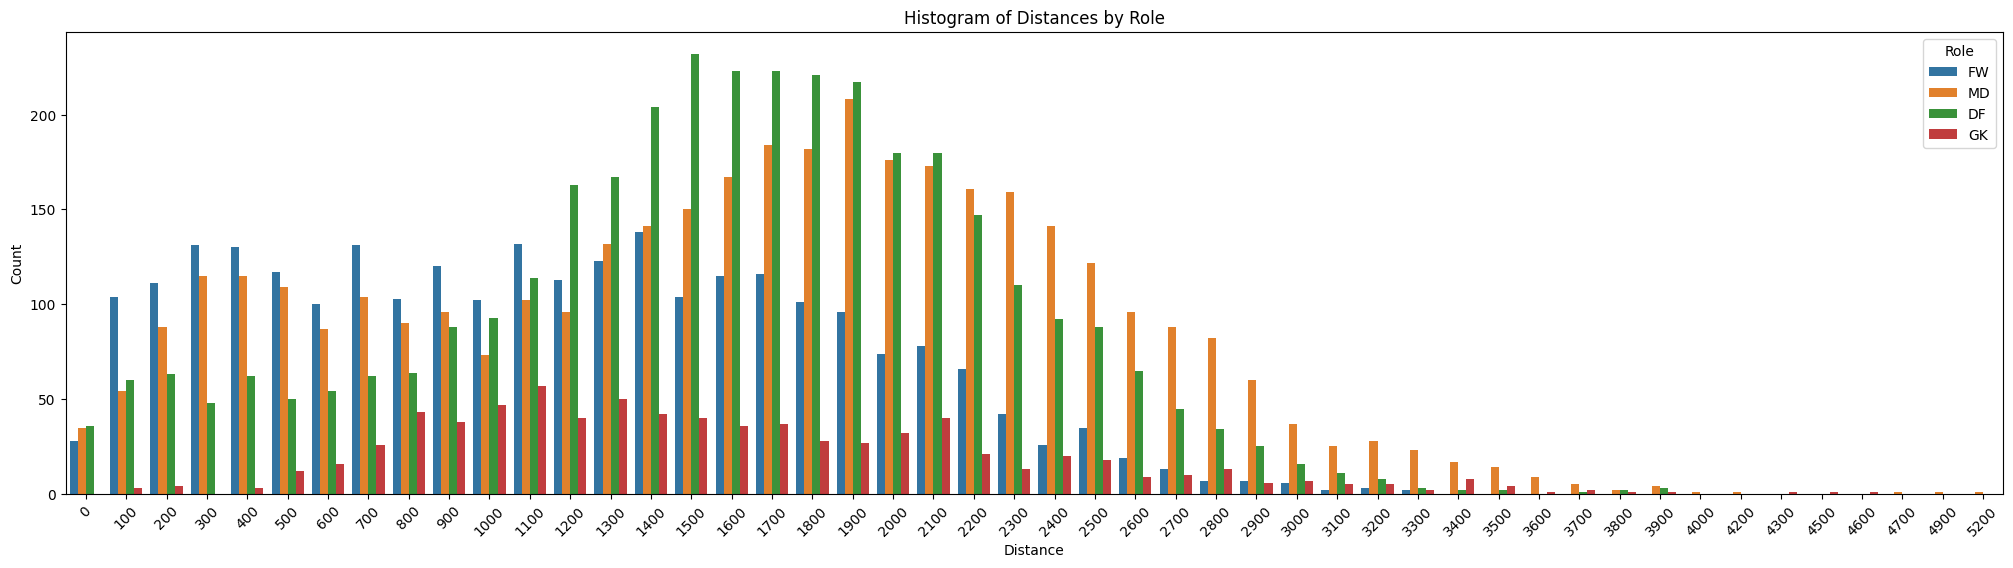

In [14]:
plot_histogram_per_role(players_role_distances_df)

## English first division analysis

In [15]:
english_events_df = prepare_events(extract_events(events_df, 'England'))

In [16]:
events_players_df = pd.merge(english_events_df, players_df, on='playerId', how='left')

In [17]:
events_players_distances_df = compute_distance(events_players_df)

In [18]:
english_tmp_df = sum_distances(events_players_distances_df)

In [19]:
distances_count = count_distances(english_tmp_df)

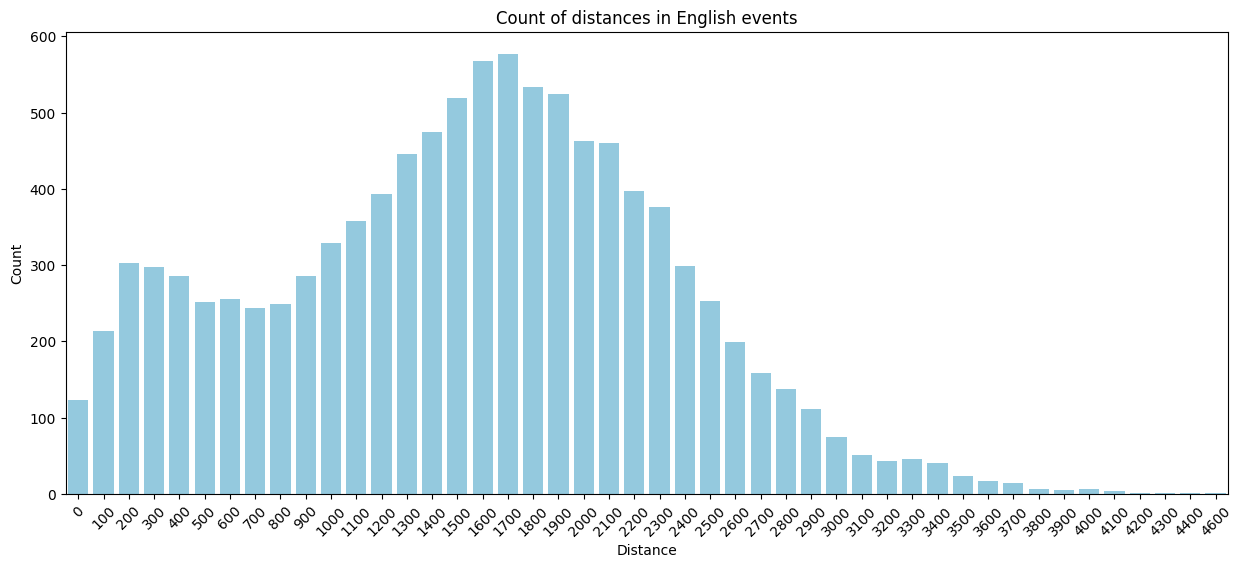

In [20]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in English events')

In [21]:
english_players_role_distances_df = pd.merge(english_tmp_df, players_df, on='playerId', how='left')

In [22]:
players_role_distances_df = group_by_distance_role(english_players_role_distances_df)

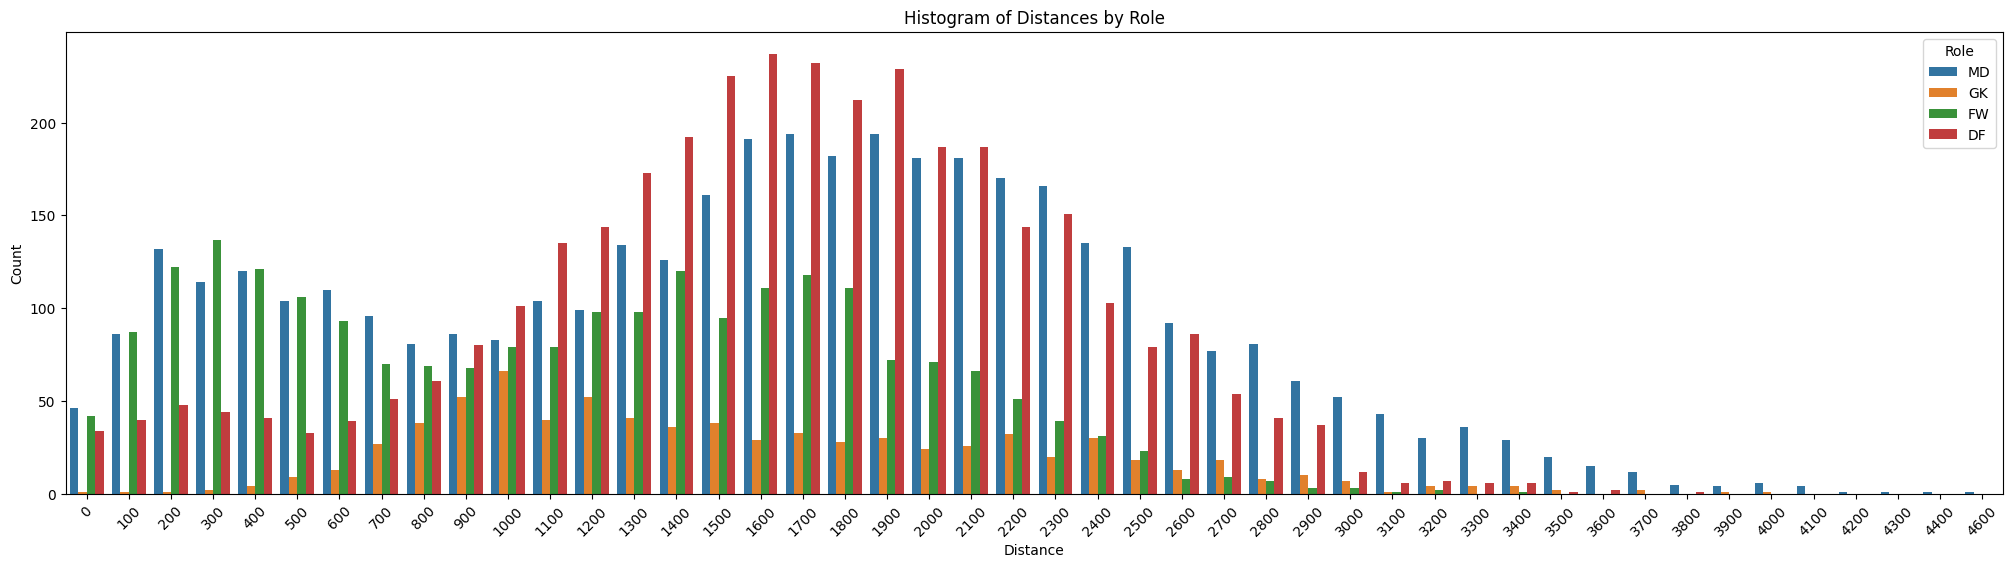

In [23]:
plot_histogram_per_role(players_role_distances_df)

## Spanish first division analysis

In [24]:
spanish_events_df = prepare_events(extract_events(events_df, 'Spain'))

In [25]:
events_players_df = pd.merge(spanish_events_df, players_df, on='playerId', how='left')

In [26]:
events_players_distances_df = compute_distance(events_players_df)

In [27]:
spanish_tmp_df = sum_distances(events_players_distances_df)

In [28]:
distances_count = count_distances(spanish_tmp_df)

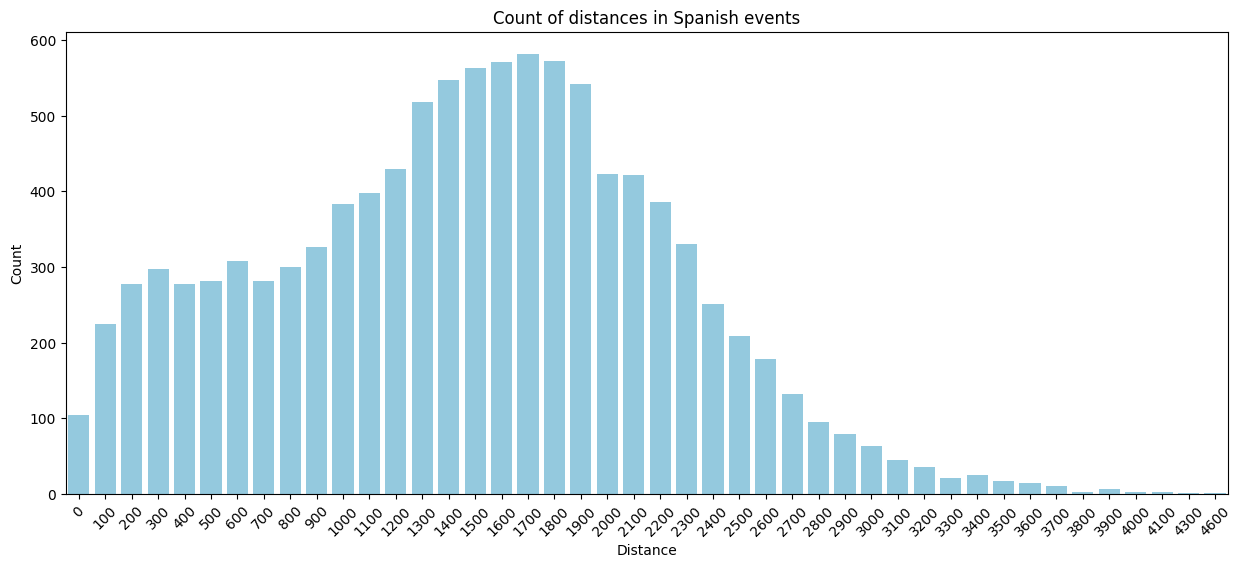

In [29]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in Spanish events')

In [30]:
spanish_players_role_distances_df = pd.merge(spanish_tmp_df, players_df, on='playerId', how='left')

In [31]:
players_role_distances_df = group_by_distance_role(spanish_players_role_distances_df)

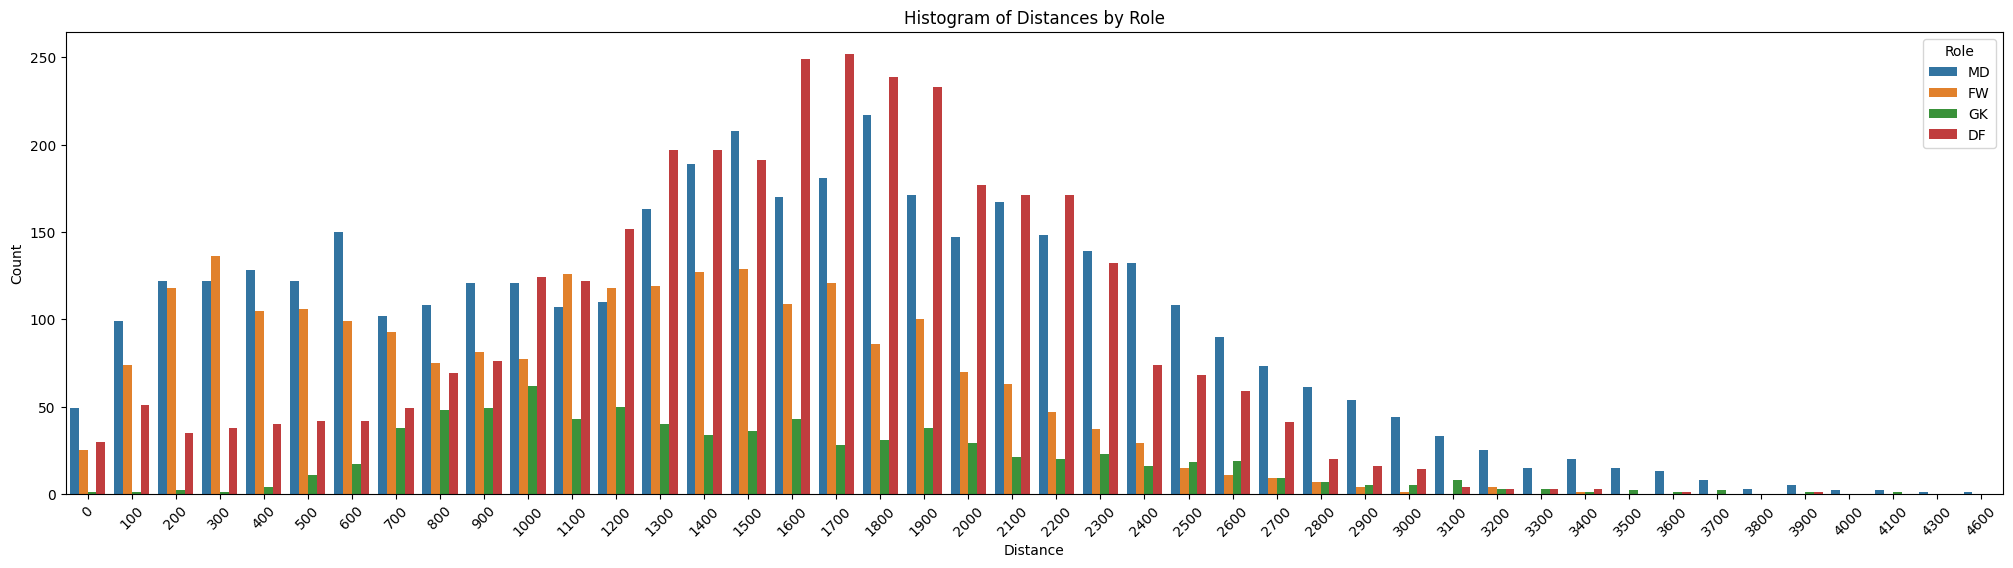

In [32]:
plot_histogram_per_role(players_role_distances_df)

## German first division analysis

In [33]:
german_events_df = prepare_events(extract_events(events_df, 'Germany'))

In [34]:
events_players_df = pd.merge(german_events_df, players_df, on='playerId', how='left')

In [35]:
events_players_distances_df = compute_distance(events_players_df)

In [36]:
german_tmp_df = sum_distances(events_players_distances_df)

In [37]:
distances_count = count_distances(german_tmp_df)

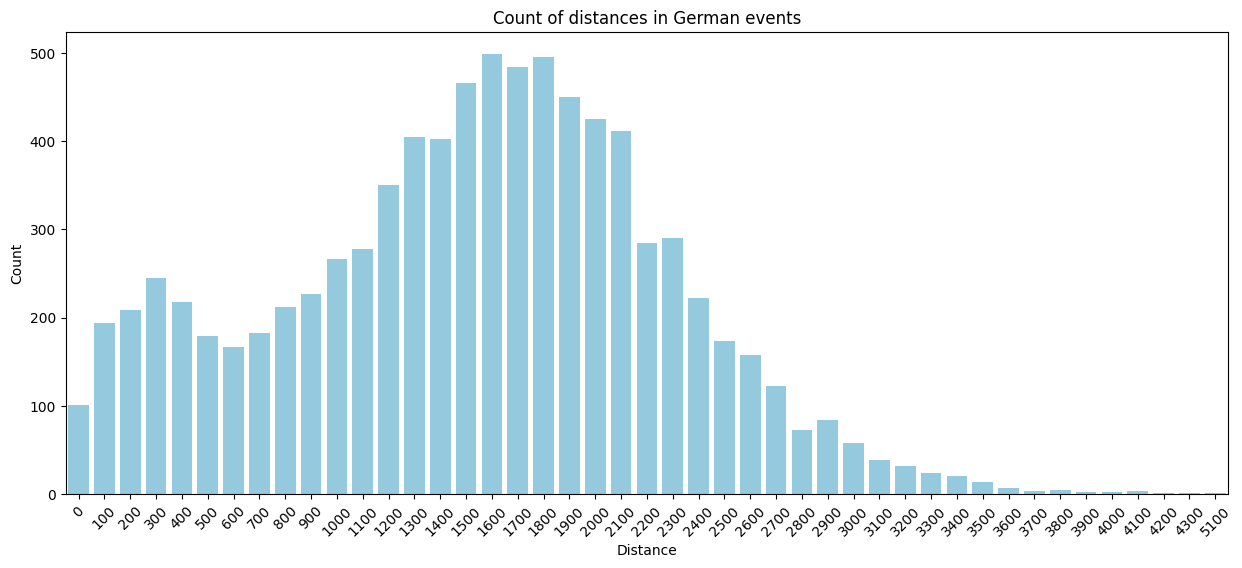

In [38]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in German events')

In [39]:
german_players_role_distances_df = pd.merge(german_tmp_df, players_df, on='playerId', how='left')

In [40]:
players_role_distances_df = group_by_distance_role(german_players_role_distances_df)

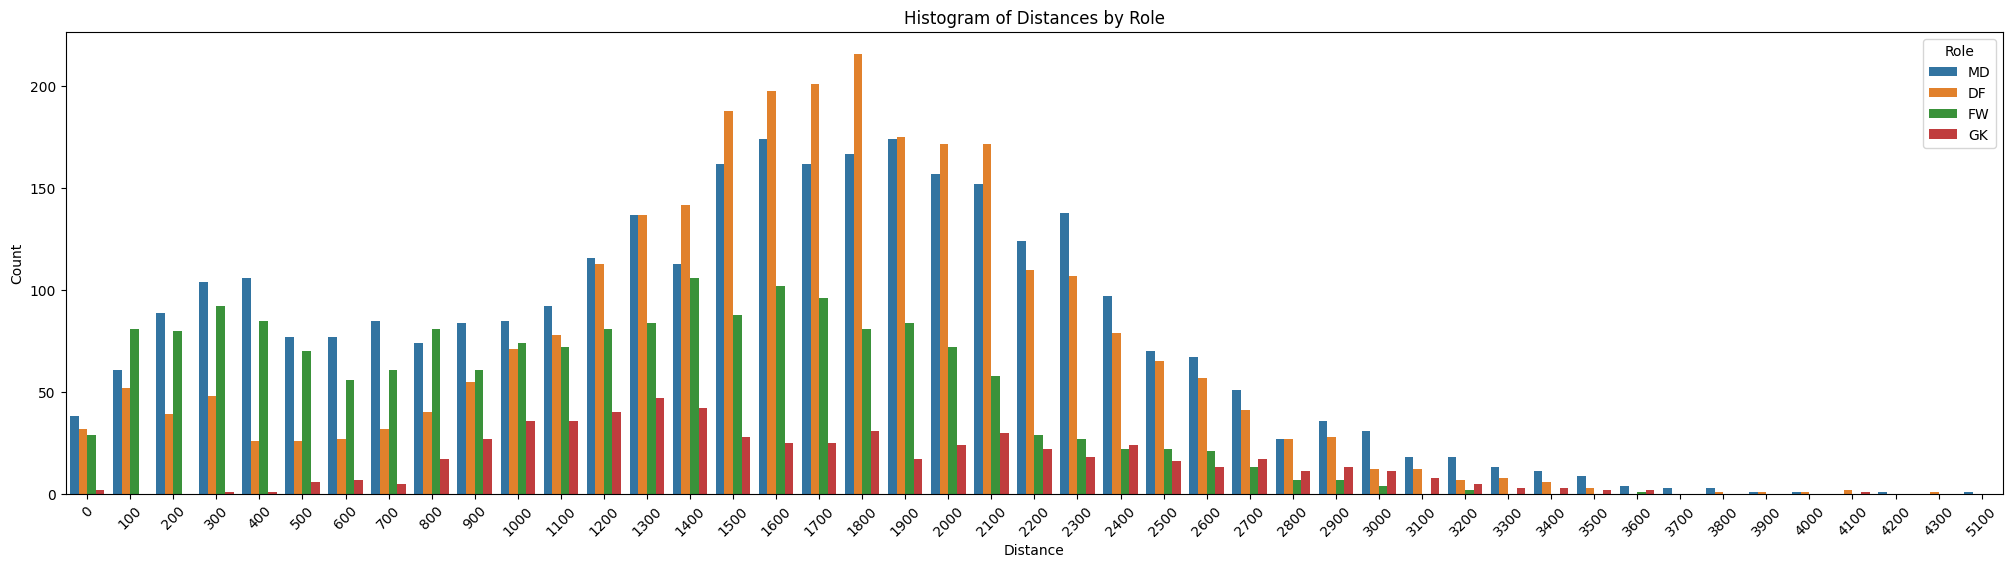

In [41]:
plot_histogram_per_role(players_role_distances_df)

## French first division analysis

In [42]:
french_events_df = prepare_events(extract_events(events_df, 'France'))

In [43]:
events_players_df = pd.merge(french_events_df, players_df, on='playerId', how='left')

In [44]:
events_players_distances_df = compute_distance(events_players_df)

In [45]:
french_tmp_df = sum_distances(events_players_distances_df)

In [46]:
distances_count = count_distances(french_tmp_df)

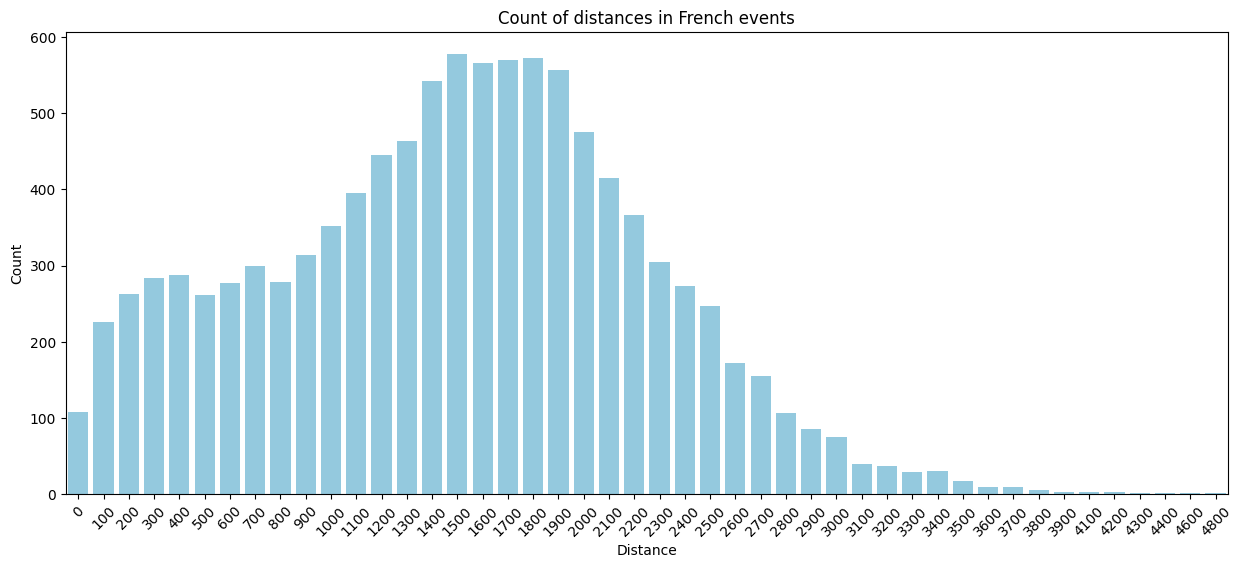

In [47]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in French events')

In [48]:
french_players_role_distances_df = pd.merge(french_tmp_df, players_df, on='playerId', how='left')

In [49]:
players_role_distances_df = group_by_distance_role(french_players_role_distances_df)

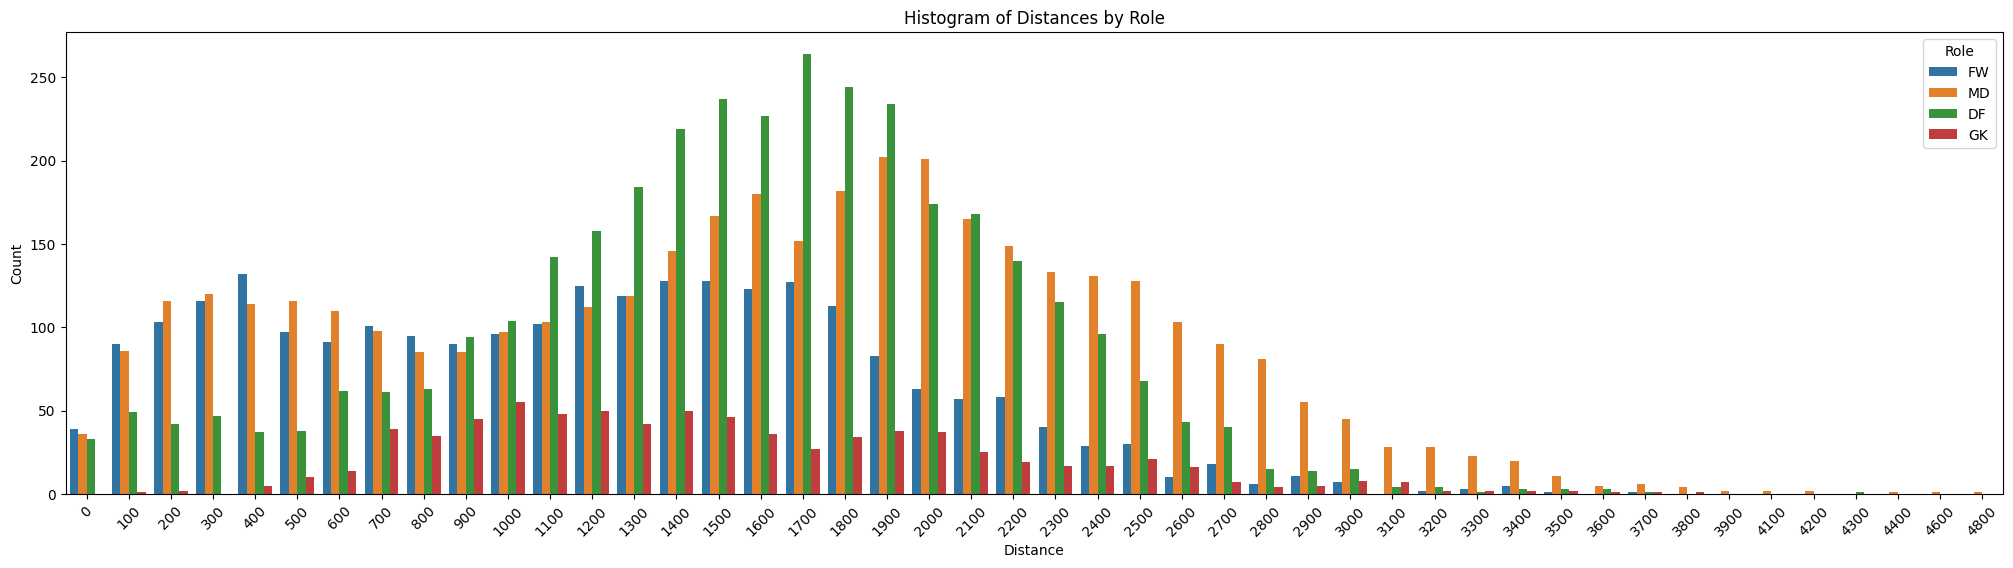

In [50]:
plot_histogram_per_role(players_role_distances_df)

## European Championship

In [51]:
european_events_df = prepare_events(extract_events(events_df, 'European_Championship'))

In [52]:
events_players_df = pd.merge(european_events_df, players_df, on='playerId', how='left')

In [53]:
events_players_distances_df = compute_distance(events_players_df)

In [54]:
european_tmp_df = sum_distances(events_players_distances_df)

In [55]:
distances_count = count_distances(european_tmp_df)

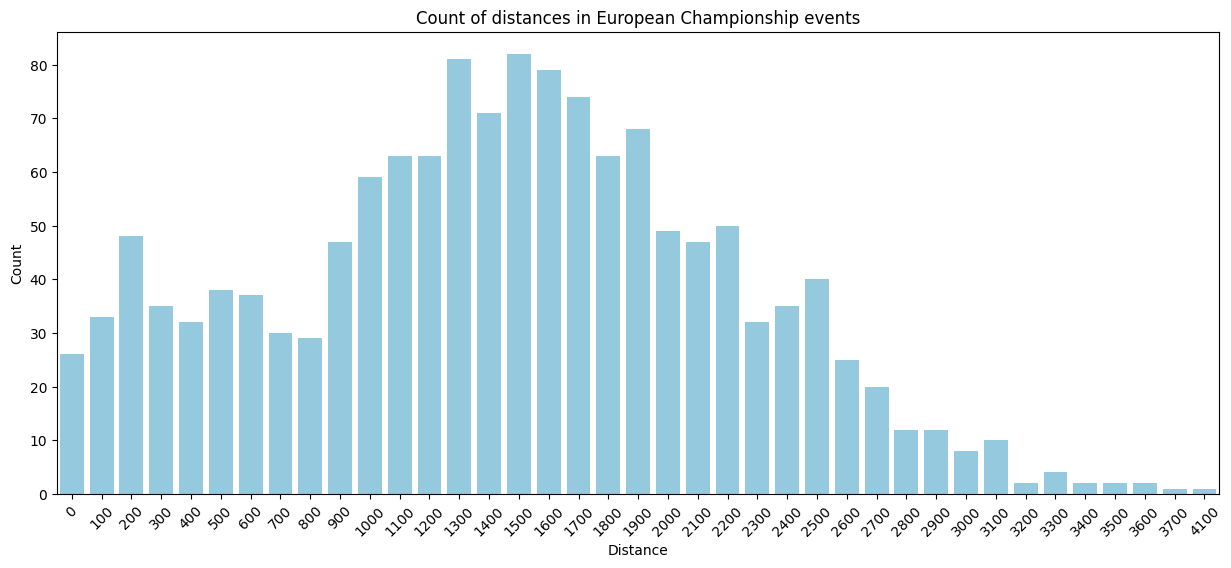

In [56]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in European Championship events')

In [57]:
european_players_role_distances_df = pd.merge(european_tmp_df, players_df, on='playerId', how='left')

In [58]:
players_role_distances_df = group_by_distance_role(european_players_role_distances_df)

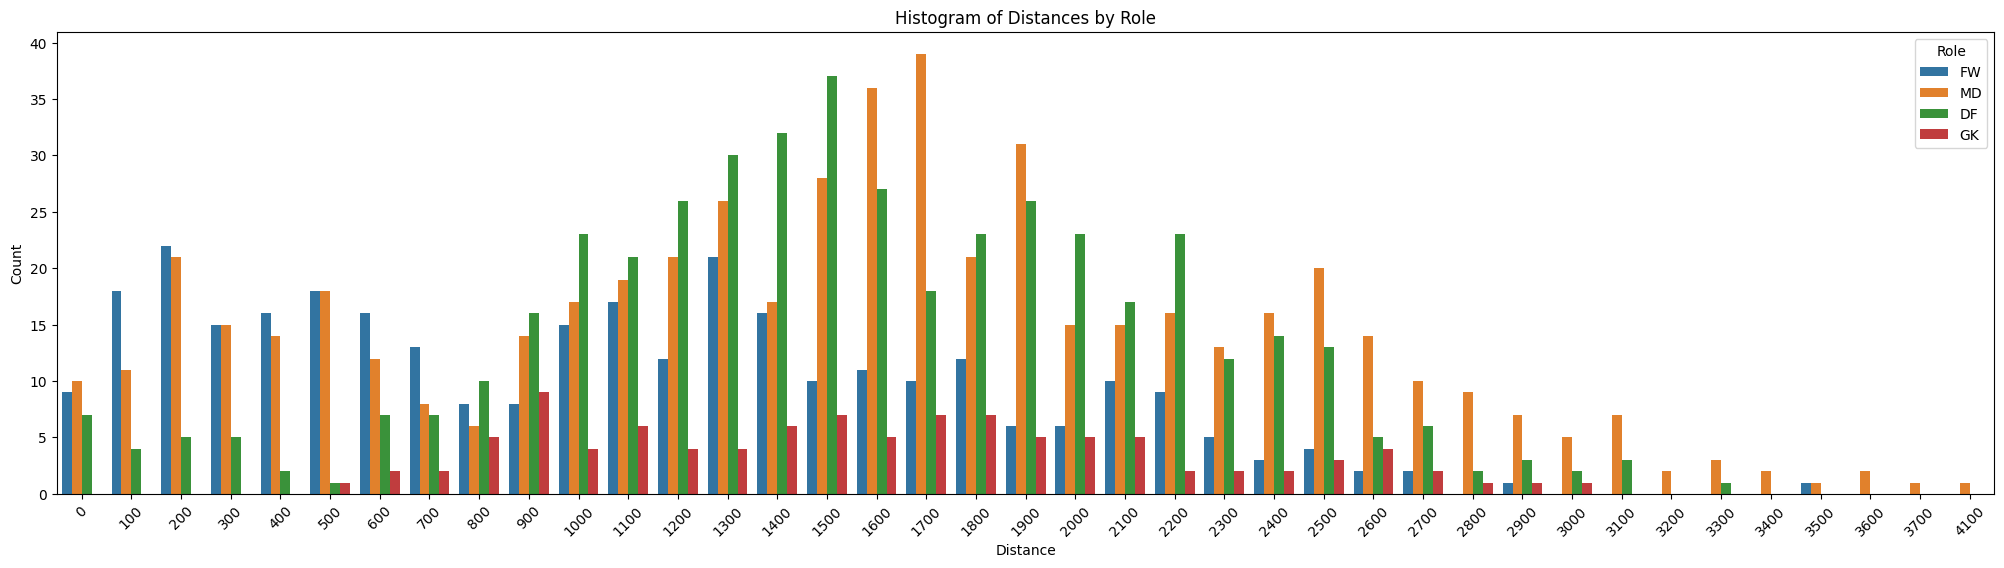

In [59]:
plot_histogram_per_role(players_role_distances_df)

## World Cup

In [60]:
world_events_df = prepare_events(extract_events(events_df, 'World_Cup'))

In [61]:
events_players_df = pd.merge(world_events_df, players_df, on='playerId', how='left')

In [62]:
events_players_distances_df = compute_distance(events_players_df)

In [63]:
world_tmp_df = sum_distances(events_players_distances_df)

In [64]:
distances_count = count_distances(world_tmp_df)

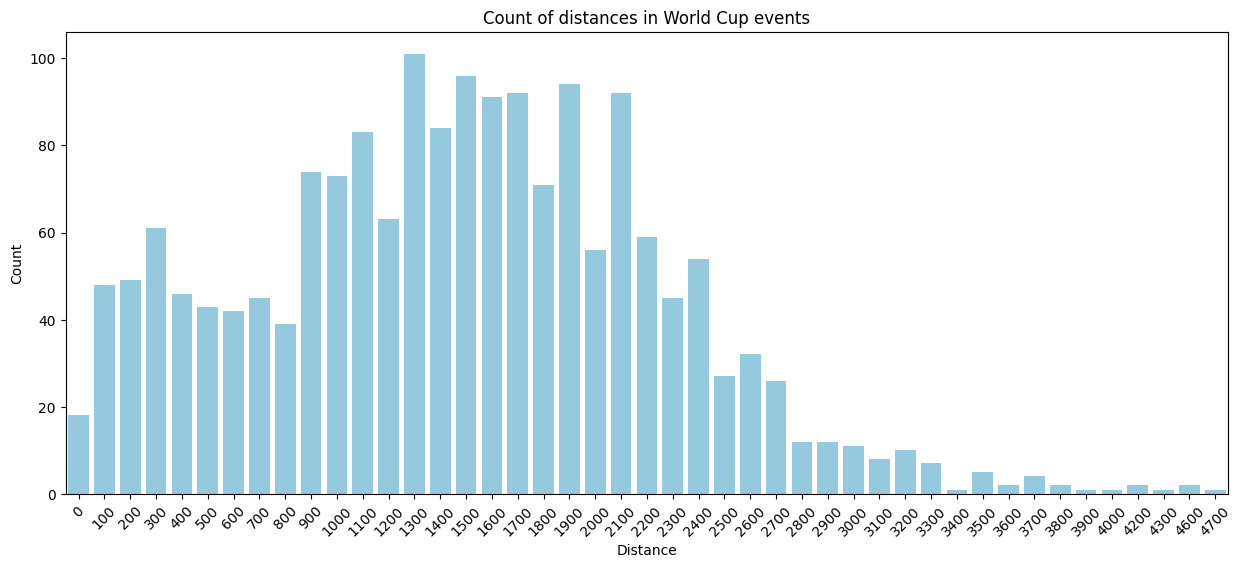

In [65]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in World Cup events')

In [66]:
world_players_role_distances_df = pd.merge(world_tmp_df, players_df, on='playerId', how='left')

In [67]:
players_role_distances_df = group_by_distance_role(world_players_role_distances_df)

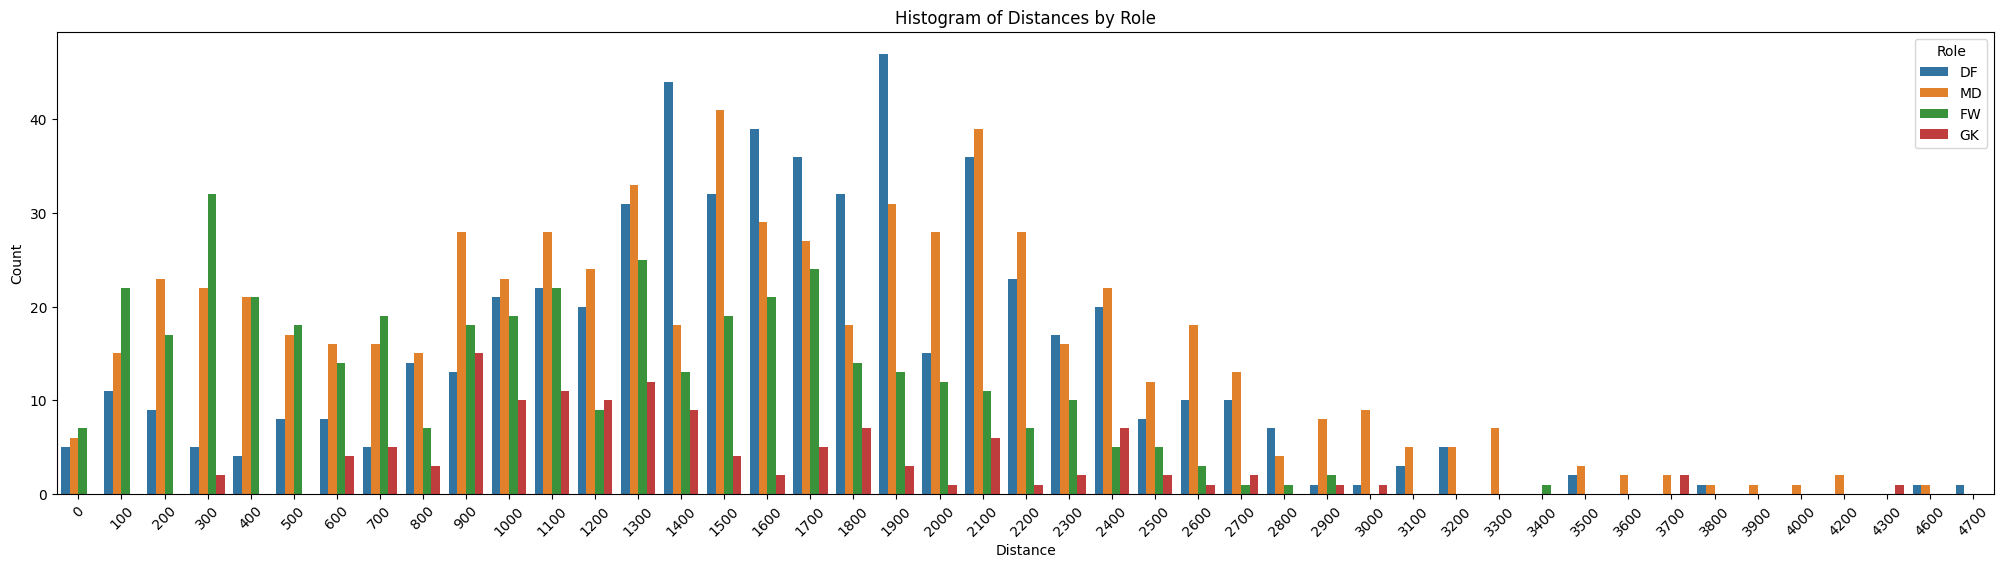

In [68]:
plot_histogram_per_role(players_role_distances_df)

### Total distances

In [69]:
total_tmp_df = pd.concat([italian_tmp_df, english_tmp_df, spanish_tmp_df, german_tmp_df, french_tmp_df, european_tmp_df, world_tmp_df])

In [70]:
distances_count = count_distances(total_tmp_df)

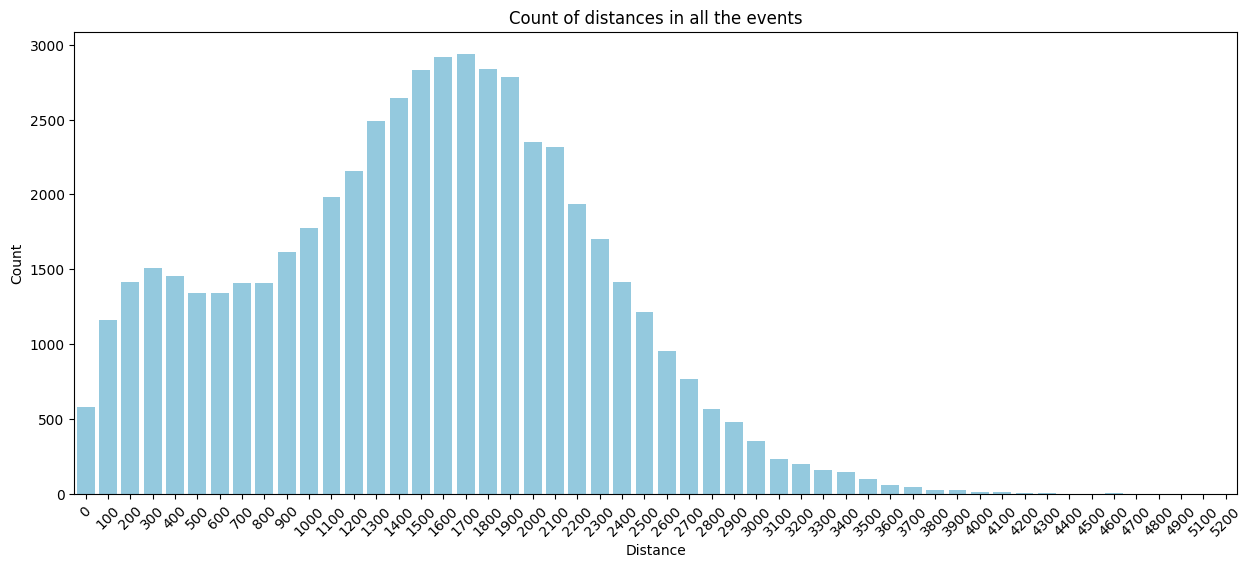

In [71]:
plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', 'Count of distances in all the events')

In [72]:
total_player_role_df = pd.concat([italian_players_role_distances_df, english_players_role_distances_df, spanish_players_role_distances_df,
                                  german_players_role_distances_df, french_players_role_distances_df, european_players_role_distances_df,
                                  world_players_role_distances_df])

In [73]:
players_role_distances_df = group_by_distance_role(total_player_role_df)

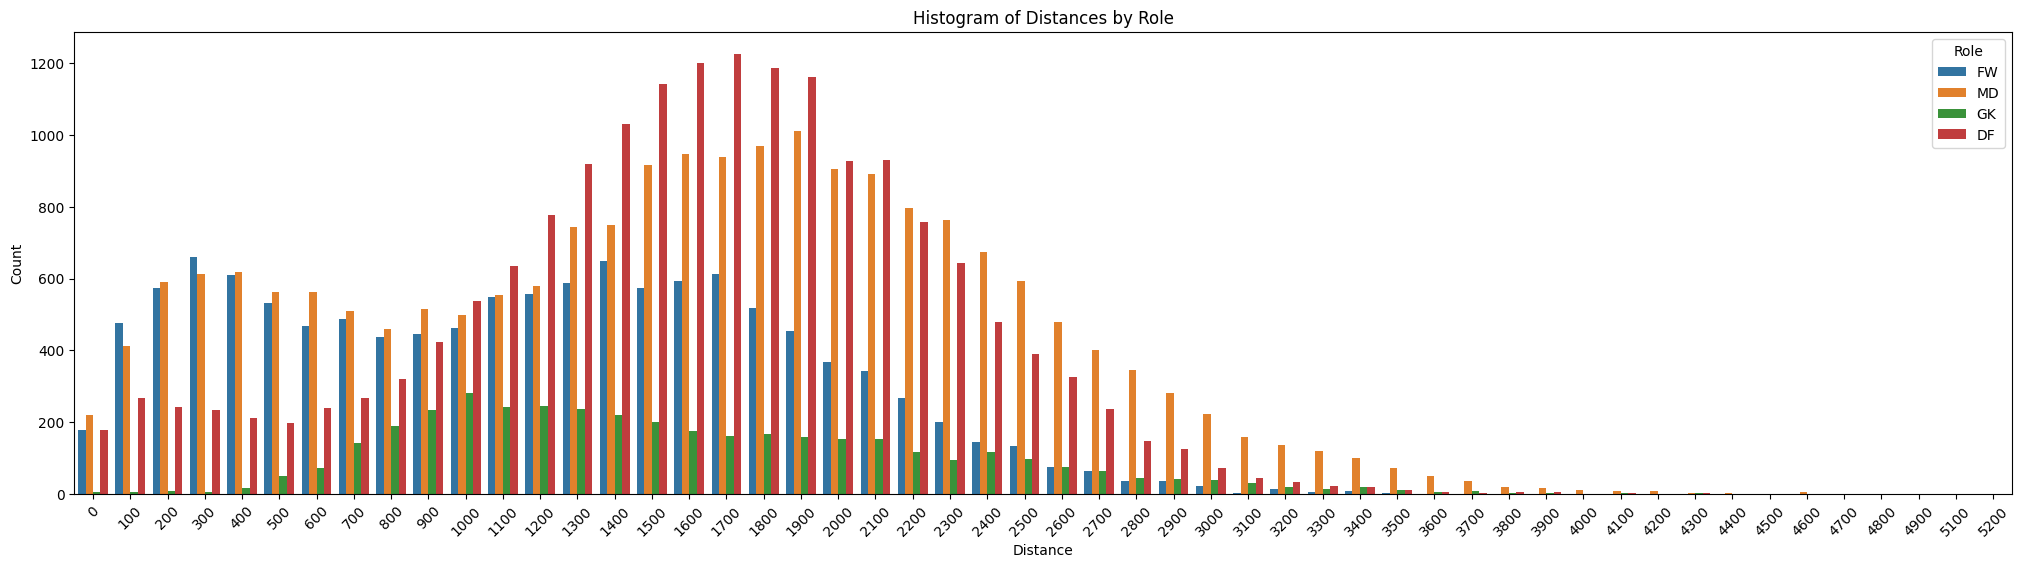

In [74]:
plot_histogram_per_role(players_role_distances_df)